In [1]:
#----- CEO: GMT ray-tracing and wavefront sensing simulator
import ceo
import numpy as np
from scipy.special import gamma, factorial

#----- Visualization
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


# Atmospheric Turbulence Emulation
This Notebook:
1. Evaluates how much stroke is needed to emulate a given turbulence strength with both DM and PTT array.
2. Verifies the turbulence modal variances distribution over the segment KL modes.

First version by fquiros.
Released: 05/21/2025

In [2]:
from atmo_disturbance import atmo_disturbance
from telescope_simulator import telescope_simulator
from gmt_pupil import gmt_pupil
from gaps_utilities import load_dictionary_from_file

## Initialize GMT pupil and atmospheric disturbance objects

In [3]:
D = 25.5 # [m] Diameter of simulated square (slightly larger than GMT diameter) 
nPx = 460
pup_angle = 0.0
array_pixscale = D / (nPx-1)
project_truss_onaxis = False

In [4]:
pup = gmt_pupil(array_size_pix=nPx, array_size_m=D, array_rot_angle=pup_angle,
               project_truss_onaxis=project_truss_onaxis)

In [5]:
L0   = 25.0   # Outer scale [m]
r0 = 12.8e-2  # Fried parameter [m]
turb_type='Independent Realizations'
atm = atmo_disturbance(pup, r0, L0, turb_type=turb_type)

Turbulence model: Independent Realizations
            r0 @ 500nm : 12.8 cm
        seeing @ 500nm : 0.79 arcsec
                    L0 : 25.0 m


Test the disturbance generator: every time the cell below is executed you will get a different realization.

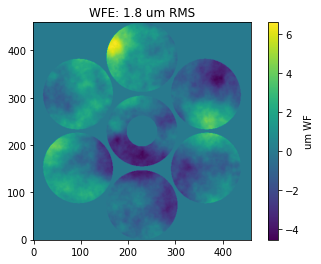

In [6]:
atm.trigger()
PhaseTur = atm.get_data()
wfe_tur = atm.get_wfe()

plt.imshow(PhaseTur*1e6, origin='lower')
plt.title("WFE: %0.1f um RMS"%(wfe_tur*1e6))
plt.colorbar(label='um WF')

## Retrieve Telescope Simulator model
This is the GAPS simulator model comprising DM+PTT.

In [7]:
#---> MEMS model parameters
ref_ifunc_fname = './data/mems2k/MagAO-X_MEMS2k_ReferenceIF.npz'
pupil_size_in_mems_pitches = 48
grid_rot_deg = -2.5

gaps = telescope_simulator(nPx, ref_ifunc_fname, array_size_m = D, array_rot_angle = pup_angle, 
                    project_truss_onaxis = project_truss_onaxis, 
                    pupil_size_in_mems_pitches = pupil_size_in_mems_pitches,
                    mems_grid_rot_angle = grid_rot_deg)

--> Initializing GMT pupil.....
--> Initializing MEMS model.....
Completed creation of influence function cube of size 460 x 460 x 2040.
--> Initializing PTT array model.....
Done! .....


## Retrieve Modal Basis Definition
Retrieve M2C data from file, and other related data, like valid DM actuators.

In [8]:
m2c_fname = "/home/ubuntu/CEO/python/ceo/gaps/data/M2C/KLF_M2C_20250520_v0.npz"
m2c_data = load_dictionary_from_file(m2c_fname)
m2c_data.keys()

Restoring data from file: KLF_M2C_20250520_v0.npz


dict_keys(['array_params', 'KLamp', 'gaps_params', 'dm_valid_acts', 'dm_valid_acts_thr', 'ifpeak', 'fkls_params', 'KLF_M2C', 'filename'])

In [10]:
KLF_M2C = m2c_data['KLF_M2C']
validacts = m2c_data['dm_valid_acts']
nvacts = len(validacts)
ifpeak = m2c_data['ifpeak']
regularization_factor = m2c_data['fkls_params']['regularization_factor']
n_mode = KLF_M2C.shape[1]

### Inverse of M2C matrx
This matrix is needed to transform a zonal command into a modal command.

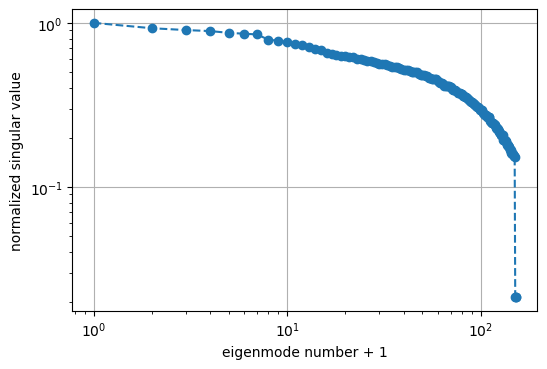

In [136]:
# SVD analysis of M2C matrices to determine whether filtering is needed.
segId = 1 # select segment index number
Uz, ss1, Vz = np.linalg.svd(KLF_M2C[:,:,segId])

fig, ax = plt.subplots()
fig.dpi = 100
ax.loglog(np.arange(n_mode)+1, ss1/np.max(ss1), 'o--')
ax.set_xlabel('eigenmode number + 1')
ax.set_ylabel('normalized singular value')
ax.grid()

In [137]:
#--- Show one of the eigenmodes,
this_eigen = len(ss1) - 1
eigenmodevec = KLF_M2C[:,:,segId] @ Vz[this_eigen,:]
pttvec, dmvec = np.split(eigenmodevec, [21])
dmcomm = np.zeros((gaps.mems2k.n_acts))
dmcomm[validacts] = dmvec

wf_dm = gaps.mems2k.get_wf(dmcomm)
wf_ptt = gaps.ptt.get_wf(pttvec)
wf_sum = (wf_dm + wf_ptt) * pup.GMTmask2D

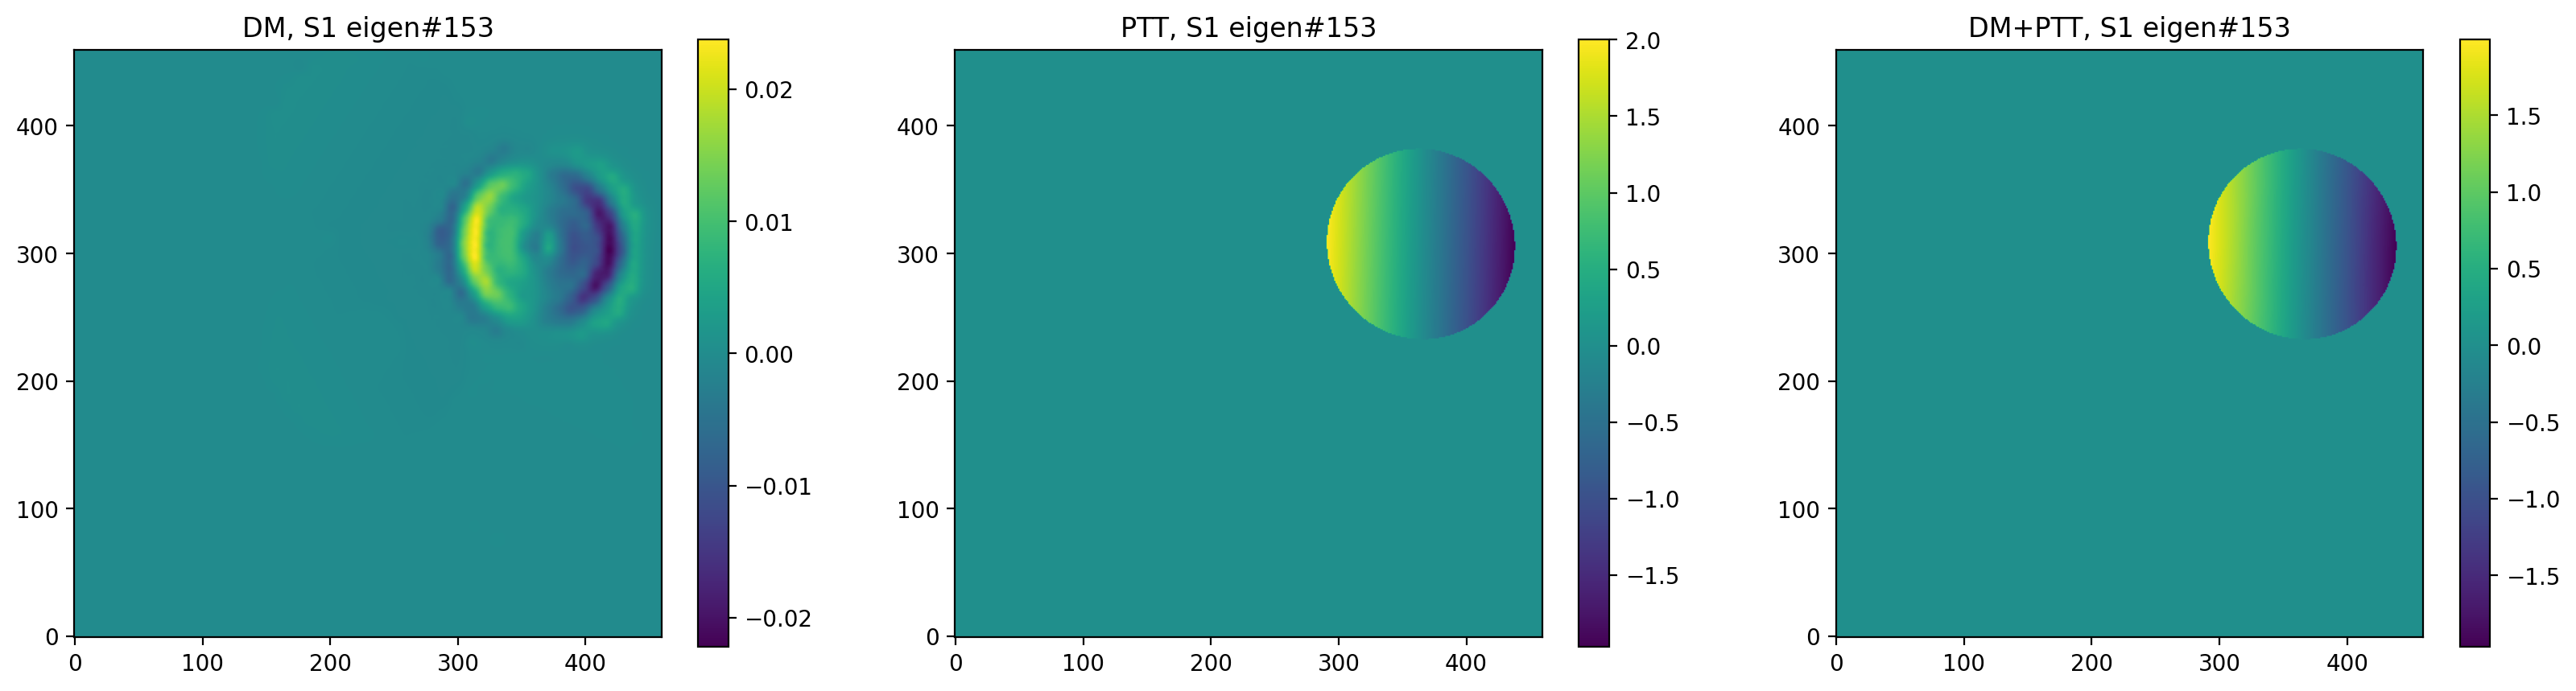

In [138]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches((20,5))
fig.dpi=200

im1 = ax1.imshow(wf_dm, origin='lower')
ax1.set_title('DM, S%d eigen#%d'%(segId, this_eigen+1))
clb1 = fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(wf_ptt, origin='lower')
ax2.set_title('PTT, S%d eigen#%d'%(segId, this_eigen+1))
clb2 = fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(wf_sum, origin='lower')
ax3.set_title('DM+PTT, S%d eigen#%d'%(segId, this_eigen+1))
clb3 = fig.colorbar(im3, ax=ax3)

Compute the inverse of M2C without any SVD thresholding.

In [16]:
inv_KLF_M2C = []
for segId in range(7):
    inv_KLF_M2C.append( np.linalg.pinv(KLF_M2C[:,:,segId]))

### Zernikes Covariance Matrix
Needed to compare to modal projections

In [24]:
def zern_num(_num_):
    n = np.floor(np.sqrt(8*_num_-7)-1) // 2
    m = np.where( (n%2)==1, 1+2*((_num_-1-(n*(n+1))//2)//2),
                              2*((_num_  -(n*(n+1))//2)//2))
    return n, m

In [25]:
def VKzernCovar(i0,j0,D,r0,L0):
    f0 = 1/L0
    cst = (2*gamma(11/6)/np.pi**(3/2))*(gamma(6/5)*24/5)**(5/6)
    ni0, mi0 = zern_num(i0)
    nj0, mj0 = zern_num(j0)
    l = len(i0)
    
    nlim=50
    k = np.arange(nlim+1)
    factk = factorial(k)
    red = (-1)**k / factk
    piDf0 = np.pi*D*f0
    
    y = np.zeros((l,l))
    
    for cpt1 in range(l):
        for cpt2 in range(l):
            i = i0[cpt1]
            j = j0[cpt2]
            ni = ni0[cpt1]
            nj = nj0[cpt2]
            mi = mi0[cpt1]
            mj = mj0[cpt2]
            
            if (~(np.abs(i-j)%2).astype('bool') or (mi==0)) and (mi==mj):
                
                G1 = gamma(11/6 +k) * gamma(-5/6 +(ni+nj)/2 -k) * gamma(7/3 +k) * gamma(17/6 +k) /  \
                (gamma(23/6 +(ni+nj)/2 +k) * gamma(17/6 +(ni-nj)/2 +k) * gamma(17/6 +(nj-ni)/2 +k))

                G2 = gamma(1 +(ni+nj)/2 +k) * gamma(5/6 -(ni+nj)/2 -k) * gamma(1.5 +(ni+nj)/2 +k) * gamma(2 +(ni+nj)/2 +k) /  \
                    (gamma(3 +(ni+nj)+k) * gamma(2 +nj+k) * gamma(2 +ni+k))

                y[cpt1,cpt2] = cst*np.sqrt((ni+1)*(nj+1))*(-1)**((ni+nj-(mi+mj))/2) * \
                    np.sum( red * (G1*piDf0**(2*k) + G2*piDf0**(2*k+ni+nj-5/3)) )

    return y * (D/r0)**(5/3)

### MEMS valid actuators
Use same set of valid actuators used for building the modal basis.

In [11]:
ifpeak2D = gaps.mems2k.get_comm_2D(ifpeak)
actvec = np.zeros(gaps.mems2k.n_acts)
actvec[validacts] = 1
actvec2D = gaps.mems2k.get_comm_2D(actvec)

print("Number of valid DM actuators: %d"%nvacts)

Number of valid DM actuators: 1527


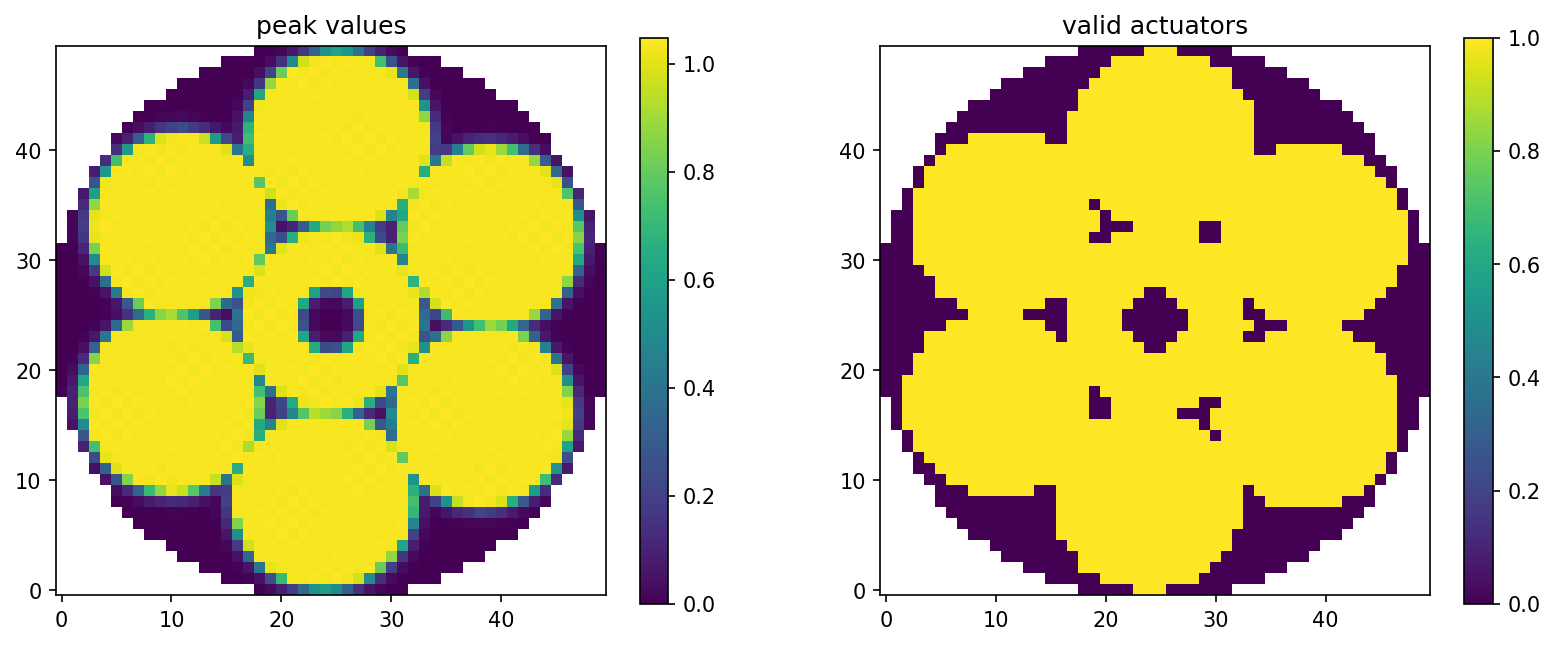

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
fig.dpi = 150

im1 = ax1.imshow(ifpeak2D, origin='lower')
clb1 = fig.colorbar(im1, ax=ax1)
ax1.set_title('peak values')

im2 = ax2.imshow(actvec2D, origin='lower')
clb2 = fig.colorbar(im2, ax=ax2)
ax2.set_title('valid actuators');

## Merged influence matrix and regularized inverse
The inverse of the merge influence matrix will be used to project the turbulence WF onto the DM+PTT space.

In [13]:
%%time
mergedIFmat, inv_mergedIFmat, DMmat_norm, PTTmat_norm = \
    gaps.get_merged_influence_matrices(validacts, regularization_factor=regularization_factor)

--> Computing Merged influence matrices.....
CPU times: user 5min 24s, sys: 28 s, total: 5min 52s
Wall time: 1min 4s


In [29]:
normDiag = 1. / np.concatenate((np.ones(21)*PTTmat_norm, \
                                np.ones(nvacts)*DMmat_norm))

In [32]:
inv_mergedIFmat_descaled = np.diag(normDiag) @ inv_mergedIFmat

## Test projection with a single phase screen realization

In [35]:
atm.trigger()
wf_tur = atm.get_data()

# Project phase map onto influence functions
myvec =  inv_mergedIFmat_descaled @ wf_tur[pup.GMTmask2D]
pttvec, dmvec = np.split(myvec, [21])

dmcomm = np.zeros((gaps.mems2k.n_acts))
dmcomm[validacts] = dmvec

# Find WF contributions from PTT and DM
#wf_tel = gaps.get_wf(dm_command=dmcomm, ptt_command=pttvec) # the sum of DM and PTT wavefronts
wf_dm = gaps.mems2k.get_wf(dmcomm)
wf_ptt = gaps.ptt.get_wf(pttvec)
wf_res = (wf_tur - (wf_dm + wf_ptt)) * pup.GMTmask2D

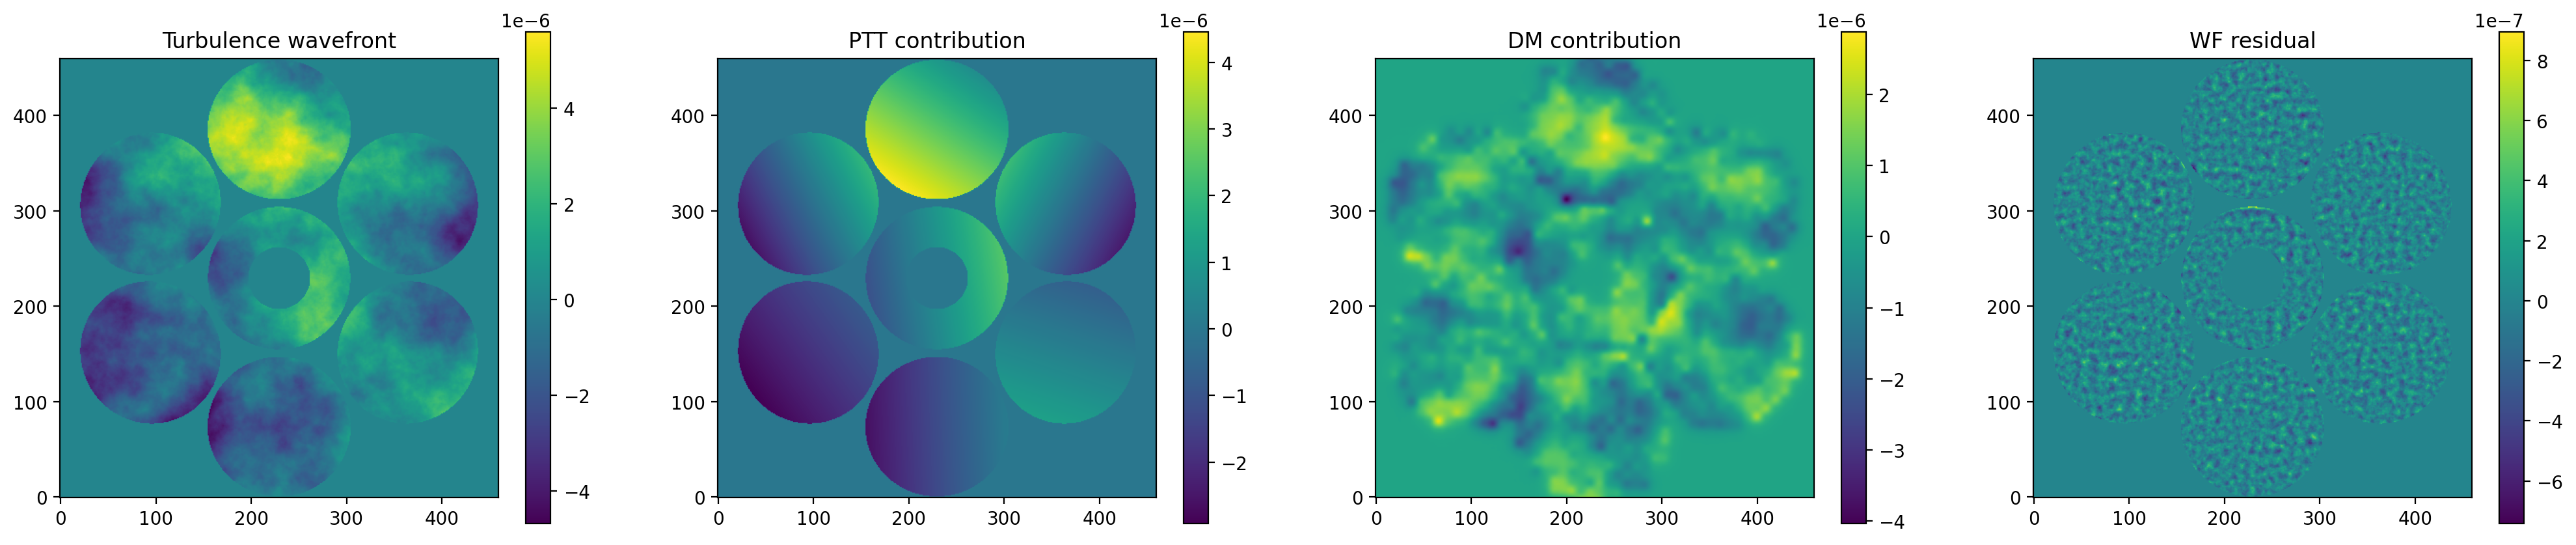

In [36]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
fig.set_size_inches((25,5))
fig.dpi=200

im1 = ax1.imshow(wf_tur, origin='lower')
clb1 = fig.colorbar(im1, ax=ax1)
ax1.set_title('Turbulence wavefront');

im2 = ax2.imshow(wf_ptt, origin='lower')
clb2 = fig.colorbar(im2, ax=ax2)
ax2.set_title('PTT contribution');

im3 = ax3.imshow(wf_dm, origin='lower')
clb3 = fig.colorbar(im3, ax=ax3)
ax3.set_title('DM contribution');

im4 = ax4.imshow(wf_res, origin='lower')
clb4 = fig.colorbar(im4, ax=ax4)
ax4.set_title('WF residual');

## Project series of independent realizations

In [81]:
%%time

niter = 10000
dmcommwf  = np.zeros((len(validacts), niter))
pttcommwf = np.zeros((21,niter))
wf_p2v = np.zeros(niter)
dm_p2v = np.zeros(niter)
pist_p2v = np.zeros(niter)
stt_p2v = np.zeros(niter)
klcoeffs = np.zeros((n_mode,7,niter))

for jj in range(niter):
    
    # Generate phase screen and extract turbulence phase map
    atm.trigger()
    wf_tur = atm.get_data()
    wf_p2v[jj] = np.max(wf_tur) - np.min(wf_tur)

    # Project phase map onto influence functions
    myvec = inv_mergedIFmat_descaled @ wf_tur[pup.GMTmask2D]
    pttvec, dmvec = np.split(np.copy(myvec), [21])
    
    # Save commands (in m wf)
    dmcommwf[:,jj] = np.copy(dmvec)
    pttcommwf[:,jj] = np.copy(pttvec)
    
    dm_p2v[jj] = np.max(dmvec) - np.min(dmvec)
    pist_p2v[jj] = np.max(pttvec[0:7]) - np.min(pttvec[0:7])
    stt_p2v[jj] = 4*np.max( np.sqrt(pttvec[7:14]**2 + pttvec[14:21]**2) )

    # Modal coefficients
    for segId in range(7):
        klcoeffs[:,segId,jj] = inv_KLF_M2C[segId] @ myvec

CPU times: user 1h 22min 21s, sys: 37min 13s, total: 1h 59min 35s
Wall time: 14min 57s


### Compute modal variances
Compare modal variances to theoretical segment Zernike modal variances.

In [84]:
# Compute the mean and variance of segment KL modes
segKLmv  = np.zeros((n_mode,7))
segKLvar = np.zeros((n_mode,7))

for segId in range(7):
    segKLmv[:,segId] = np.mean(klcoeffs[:,segId,:], axis=1)*1e9   # already in nm WF
    segKLvar[:,segId] = np.var(klcoeffs[:,segId,:], axis=1)*(1e9)**2   # already in nm^2 WF

In [85]:
# Theoretical Zernike coefficients variance (for a full 25-m and 8.4-m aperture)
wavelength = 500e-9
VKzernVar_Dseg = np.diag(VKzernCovar(np.arange(n_mode)+1, np.arange(n_mode)+1, 8.4,  r0, L0))  # in rad^2
VKzernVar_Dtel = np.diag(VKzernCovar(np.arange(n_mode)+1, np.arange(n_mode)+1, 25.4, r0, L0)) # in rad^2

# Phase RMS [nm WF] according to Zernike VK statistics
print("Theoretical phase RMS computed as the sum of Zernike coeffs variances: %3.1f"%(np.sqrt(np.sum(VKzernVar_Dtel))*(wavelength/(2*np.pi))*1e9))

<ipython-input-25-4034bdd2c61d>:31: RuntimeWarning: overflow encountered in multiply
  (gamma(3 +(ni+nj)+k) * gamma(2 +nj+k) * gamma(2 +ni+k))


Theoretical phase RMS computed as the sum of Zernike coeffs variances: 1852.7


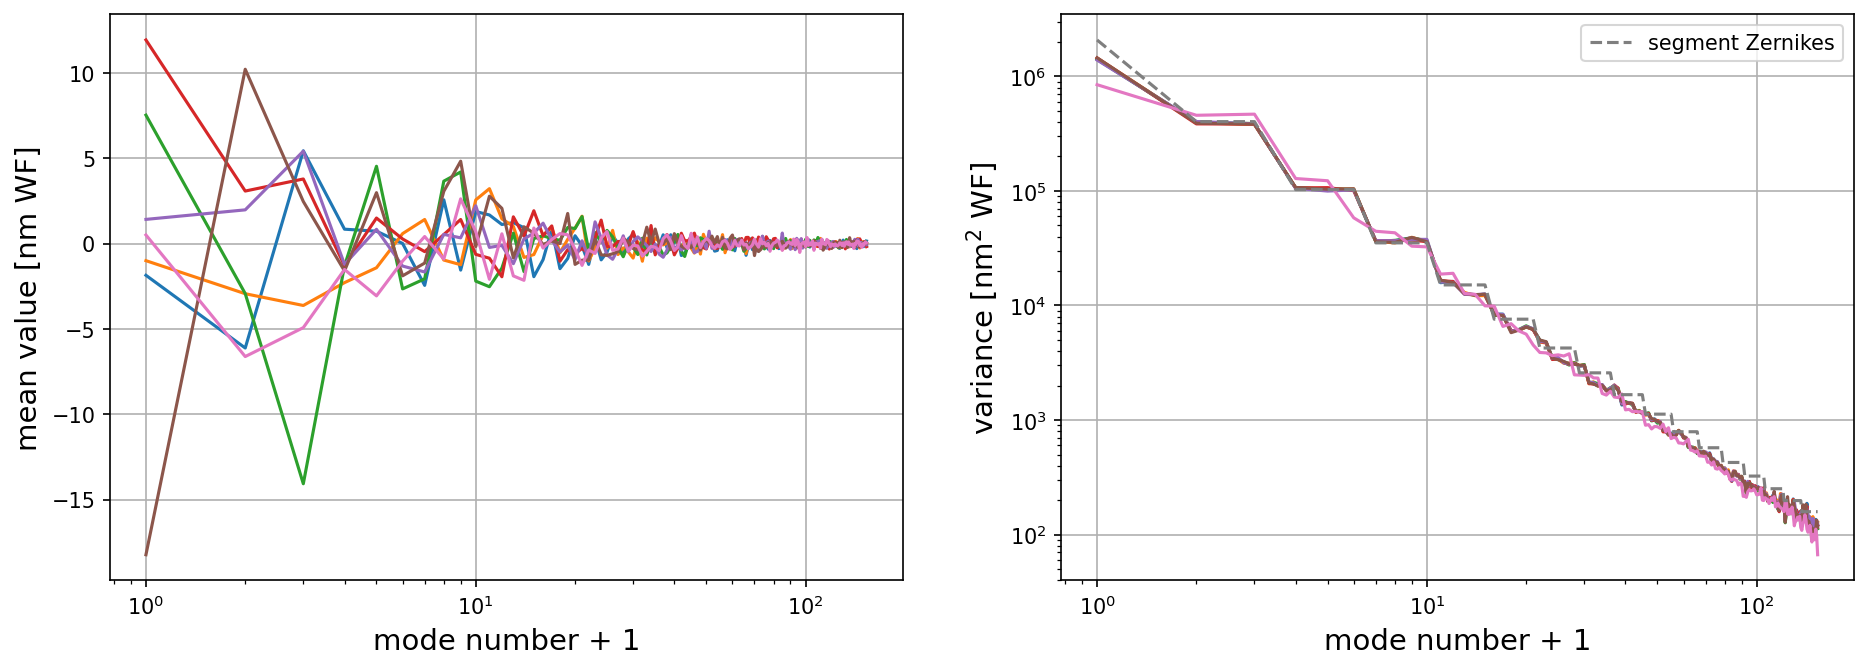

In [90]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
fig.dpi=150

ax1.semilogx(np.arange(n_mode)+1, segKLmv)
ax1.grid()
ax1.set_xlabel('mode number + 1', fontsize=14)
ax1.set_ylabel('mean value [nm WF]', fontsize=14)

ax2.loglog(np.arange(n_mode)+1, segKLvar)
ax2.plot(  np.arange(n_mode)+1, VKzernVar_Dseg*(wavelength*1e9/(2*np.pi))**2, '--',label='segment Zernikes')
#ax2.plot(  np.arange(n_mode)+1, VKzernVar_Dtel*(wavelength*1e9/(2*np.pi))**2, '--',label='Zern tel')
ax2.grid()
ax2.set_xlabel('mode number + 1', fontsize=14)
ax2.set_ylabel('variance [nm$^2$ WF]', fontsize=14)
ax2.legend()

### DM and PTT stroke analysis
Compute WF P2V statistics.

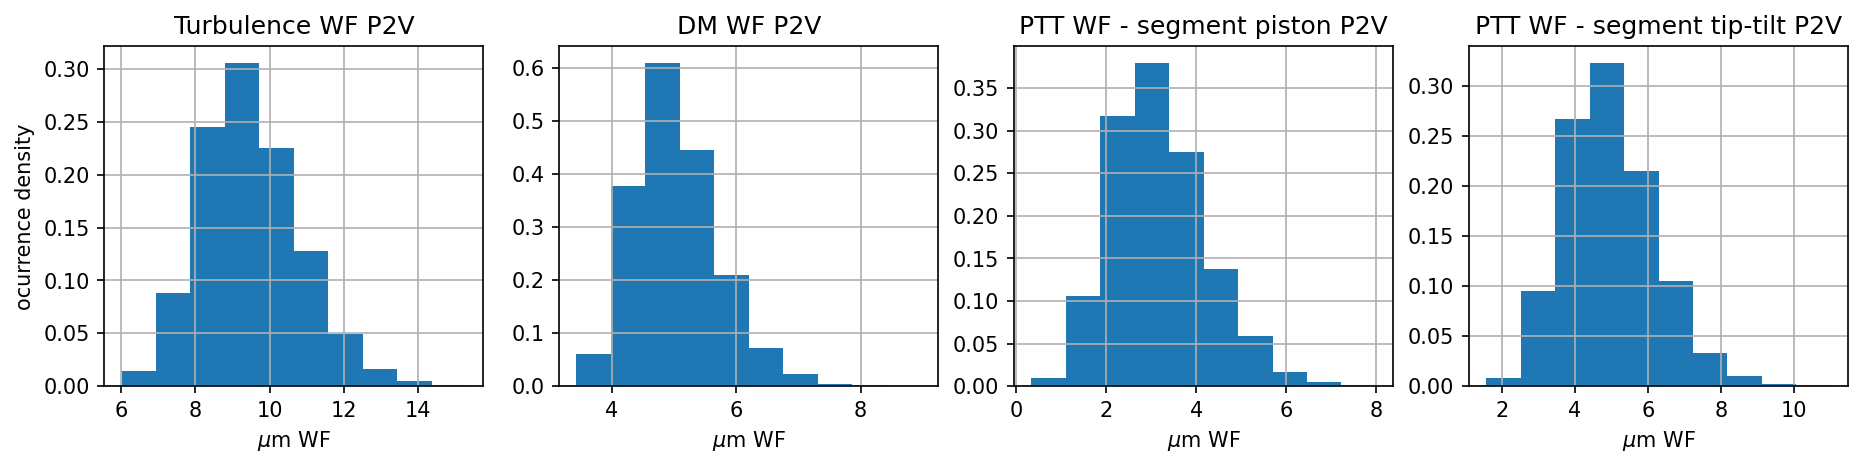

In [87]:
fig, (ax0, ax1,ax2,ax3) = plt.subplots(ncols=4)
fig.set_size_inches((15,3))
fig.dpi=150


ax0.hist(wf_p2v*1e6, density=True)
ax0.set_title('Turbulence WF P2V')
ax0.grid()
ax0.set_xlabel('$\mu$m WF')
ax0.set_ylabel('ocurrence density')

ax1.hist(dm_p2v*1e6, density=True)
ax1.set_title('DM WF P2V')
ax1.grid()
ax1.set_xlabel('$\mu$m WF')

ax2.hist(pist_p2v*1e6, density=True)
ax2.set_title('PTT WF - segment piston P2V')
ax2.grid()
ax2.set_xlabel('$\mu$m WF')

ax3.hist(stt_p2v*1e6, density=True)
ax3.set_title('PTT WF - segment tip-tilt P2V')
ax3.grid()
ax3.set_xlabel('$\mu$m WF');

In [89]:
data = [
    ("Turbulence", np.mean(wf_p2v)*1e6, np.max(wf_p2v)*1e6),
    ("DM",        np.mean(dm_p2v)*1e6, np.max(dm_p2v)*1e6),
    ("PTT - SPP", np.mean(pist_p2v)*1e6, np.max(pist_p2v)*1e6),
    ("PTT - STT", np.mean(stt_p2v)*1e6, np.max(stt_p2v)*1e6)    
]

print("{:<15} {:<13} {:<15}".format("WF P2V", "mean [um]", "max [um]"))
print("-" * 38)
for item, mean, maxx in data:
    print("{:<15} {:<13.3f} {:<3.3f}".format(item, mean, maxx))

WF P2V          mean [um]     max [um]       
--------------------------------------
Turbulence      9.489         15.286
DM              5.033         8.969
PTT - SPP       3.166         7.990
PTT - STT       4.969         11.009
